# 05 - Sentiment analysis by country - Exercise 2

In [1]:
%matplotlib inline
import pycountry
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

/Users/Sym/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
##### JUST RUN ONCE ######
# import nltk
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

As we did for the first exercise, we pre-process the data by using a tokenizer and keeping only the relevant tokens (removing stopwords, digits/numbers words and tokens that are too small).

In [3]:
path_emails = 'hillary-clinton-emails/Emails.csv'

emails = pd.read_csv(path_emails, usecols=['ExtractedSubject','ExtractedBodyText'])
emails.fillna(' ', inplace=True)
emails['subject_body'] = emails['ExtractedSubject'] + ' ' + emails['ExtractedBodyText']
emails_raw = np.asarray(emails['subject_body'])

email_tokens = []

for email in emails_raw:
    email_tokens.append(regexp_tokenize(email, pattern='\w+'))
    
stop_words = set(stopwords.words('english'))
stopwords_emails = ['fyi', 'fm', 'am', 'pm', 'n\'t', 'sent', 'from', 'to', 'subject', 'fw', 'fwd', 'fvv',
                    'cc', 'bcc', 'attachments', 're', 'date', 'html', 'php']
stop_words.update(stopwords_emails)

email_clean_tokens = []

# remove stopwords and numbers
for email in email_tokens:
    clean_tokens = [token for token in email if token.lower() not in stop_words 
                    and any(char.isdigit() for char in token) == False 
                    and len(token) > 1]
    email_clean_tokens.append(clean_tokens)

This function is used to compute the countries mentioned on each email. Moreover, we compute the number of occurences of those countries on each email, and the total number of occurences of each country (we store these values in a dataframe).

In order to do this, we use the library pycountry to get the name and the codes (2 and 3 letters) of the countries. Only Syria is missing from the list, so we add it manually.
For the country names, we first apply the lowercase function to the token ensuring this way some kind of normalization. We don't do that on the country's codes because we assume that if they are present, they will be in capital letters.

In [4]:
def get_countries(email_tokens, df):
    countries = dict()
    for token in email_tokens:
        for country in pycountry.countries:
            if (token.lower() == country.name.lower()
               or token == country.alpha_2
               or token == country.alpha_3):
                if (country.name in countries):
                    countries[country.name] += 1
                else:
                    countries[country.name] = 1
                df.set_value(country.name, 'number occurences', df.get_value(country.name, 'number occurences') + 1)
        if (token.lower() == 'syria'):
            if ('Syria' in countries):
                countries['Syria'] += 1
            else:
                countries['Syria'] = 1
            df.set_value('Syria', 'number occurences', df.get_value('Syria', 'number occurences') + 1)
    return countries

We create a dataframe with countries as indexes and 2 columns to keep track of the number of occurences on the corpus and the polarity sentiment associated. We initialize all the values to 0.

In [5]:
countries = ['Syria']
for country in pycountry.countries:
    countries.append(country.name)
    
df = pd.DataFrame(index=countries, columns=['number occurences', 'polarity sentiment'])
df.fillna(0.0, inplace=True)
df.head()

,number occurences,polarity sentiment
Syria,0.0,0.0
Aruba,0.0,0.0
Afghanistan,0.0,0.0
Angola,0.0,0.0
Anguilla,0.0,0.0


Using the function mentioned above, we fill the dataframe with the required information.
Furthermore, we get a list of dictionaries with the keys being the countries and the values being the number of occurences by email.

In [6]:
### Takes some time to compute everything ###
all_countries = []
for email in email_clean_tokens:
    all_countries.append(get_countries(email, df))

Using the *sentiment intensity analyzer*, we compute the polarity score for each email. This will analyze each email and return the sentiment strength based on it as a float.
We then take the number of occurences of each country mentioned in the email to update its polarity level on the dataframe.

In [7]:
### Takes some time to compute everything ###
all_sentiments = []
sia = SentimentIntensityAnalyzer()
for i in range(len(email_clean_tokens)):
    sentiment = sia.polarity_scores(emails_raw[i])['compound']
    for country in all_countries[i].keys():
        df.set_value(country, 'polarity sentiment', df.get_value(country, 'polarity sentiment') + sentiment * all_countries[i][country])
    all_sentiments.append(sentiment)

Since we have too many countries, we filter the results and keep only the most mentioned countries.

Finally, to get a more standardized value, we divide the previous polarity score by the total number of occurences of each country.

In [8]:
clean_df = df.copy()
clean_df = clean_df.loc[clean_df['number occurences']  >= 25.0]

clean_df['polarity level'] = clean_df['polarity sentiment'] / clean_df['number occurences']
clean_df.sort_values(['polarity level'], inplace=True)
clean_df

,number occurences,polarity sentiment,polarity level
Greece,28.0,-5.7619,-0.205782
France,47.0,-7.1604,-0.152349
Syria,31.0,1.6793,0.054171
Iraq,210.0,13.5579,0.064561
Sudan,61.0,5.7450,0.094180
Poland,41.0,4.0406,0.098551
Libya,224.0,31.0824,0.138761
Jordan,35.0,5.8015,0.165757
Germany,76.0,15.5061,0.204028
Honduras,98.0,20.3859,0.208019


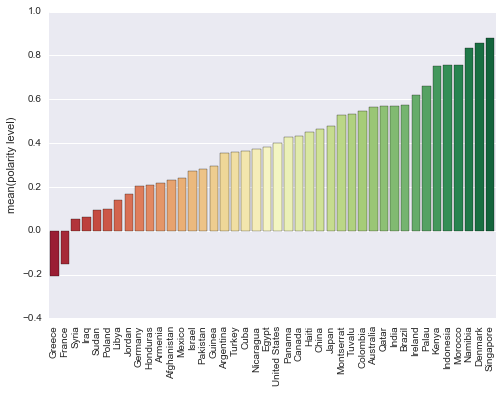

In [9]:
plt.xticks(rotation=90)
graph = sns.barplot(x=clean_df.index, y=clean_df['polarity level'], palette='RdYlGn')